# Provable Robustness for Deep Classifiers

In this notebook, we will implement the robustness certificate that we derived in the PDF. That is, we will first define and train a three-layer neural classifier; then, we will calculate its dual, and using this, check whether the classifier is dual at given input points.

**Your task is to fill in any sections labeled TODO in the code and answer the bolded questions.**

## Torch

We are using torch here; for our purposes, we can think of torch as essentially numpy with GPU support and and automatic differentiation. That is, for any function we compute, torch automatically keeps track of the function's gradient with respect to inputs; this will make gradient descent much easier to implement. 

The primary object you will need to manipulate here is `torch.Tensor`, which can be thought of as equivalent to  `np.array`. Indexing, splicing, multiplication, etc. will work like you would expect them to in numpy.

Also, most of the numpy functions you are used to are present in torch, with the same name. E.g:
* `np.max(input, axis)` --> `torch.max(input, dim)` (Note that `torch.max` actually returns a tuple of the max and argmax).
* `np.zeros` --> `torch.zeros`
* `np.eye` --> `torch.eye`
* `np.linalg.norm(x, ord, axis)` --> `torch.norm(input, p, dim)`

For more information, refer to the [torch documentation](https://pytorch.org/docs/stable/torch.html) or the [torch tutorials](https://pytorch.org/tutorials/).

## Setup

Here, we import the relevant libraries.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import copy

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This line tells torch to use the GPU if available, and otherwise the CPU.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Load the in the reconstructed sparse images 

In [3]:
from torch.utils.data import Dataset


class SparseDataset(Dataset):
    def __init__(self, images_array, labels_array):
        self.images = images_array
        self.labels = labels_array

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = torch.tensor(image, dtype=torch.float32) / 255.0
        image = image.unsqueeze(0)
        return [image, label]

Here, we load in the MNIST dataset. The inputs are $28\times 28$ images of handwritten digits, while the labels are the corresponding digit. Note that we split the data between a training set and a test set. In order to have an unbiased estimate of the classifier's performance, we must train the model only on the training set (**never the test set**), then test its accuracy on the test set.

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

This is a utility function to visualize torch Tensors as images.

In [5]:
def imshow(img):
    '''
    Visualizes IMG.
    IMG should be a 2D torch Tensor.
    '''
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(npimg, cmap='gray')
    plt.show()

## Primal Network

Here, we define the neural classifier we will be using. Note that the network comprises three layers. The first layer has dimension $28^2$ since this is the size of the input image. (The original inputs are square images, but we flatten them into a $28^2\times 1$ vector in order to feed them into the network.) The output layer has dimension $10$, since there are ten possible output classes (the digits 0-9). The hidden layer has dimension $256$. (There isn't as much science behind choosing the dimensionality of input layers; we choose $256$ because it is a round number, and is hopefully enough to the neccesary encode information about the input image.)

In [6]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.fc1 = nn.Linear(in_features=28*28, out_features = 256)
    self.fc2 = nn.Linear(in_features=256, out_features = 10)
    self.layers = [self.fc1, self.fc2]

  # define forward function
  def forward(self, t):
    '''
    On input T, performs a affine transformation, then
    a ReLU, then another affine transformation.
    '''
    self.z = []
    t = t.reshape(-1, 28*28)
    t = self.fc1(t)
    self.z.append(t)
    t = F.relu(t)
    t = self.fc2(t)
    self.z.append(t)
    return t

Here is the training code, which uses Adam, a variant of gradient descent. The actual optimization machinery is all abstracted away behind the torch library; all the work is being done by the `optimizer.step()` call.

In [7]:
def train(net, criterion, trainloader, lr=0.001):
    '''
    Uses the Adam optimization algorithm to train 
    the classifier NET on training data from TRAINLOADER,
    on loss function CRITERION, with learning rate LR.
    
    Note that we half the learning rate each epoch.
    '''
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    for epoch in range(3):
        for i, data in enumerate(trainloader, 0):
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * 0.5 ** (epoch)

            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            if i % 500 == 0:
                print('Epoch', epoch, 'Iter:', i, 'Loss', loss.item())

We can now train the net on the training data, using cross entropy loss.

In [8]:
net = Net()
net.to(device)

criterion = nn.CrossEntropyLoss()

train(net, criterion, trainloader, 0.001)

# Define the file path where you want to save the weights
weights_path = 'net_weights.pth'

# Save the state_dict of the network
torch.save(net.state_dict(), weights_path)

Epoch 0 Iter: 0 Loss 2.3293991088867188
Epoch 0 Iter: 500 Loss 0.8085342049598694
Epoch 0 Iter: 1000 Loss 0.027872901409864426
Epoch 0 Iter: 1500 Loss 0.5332754850387573
Epoch 0 Iter: 2000 Loss 1.02693510055542
Epoch 0 Iter: 2500 Loss 0.1423717886209488
Epoch 0 Iter: 3000 Loss 0.6622007489204407
Epoch 0 Iter: 3500 Loss 0.08240413665771484
Epoch 0 Iter: 4000 Loss 0.20975607633590698
Epoch 0 Iter: 4500 Loss 0.065704844892025
Epoch 0 Iter: 5000 Loss 0.3830789625644684
Epoch 0 Iter: 5500 Loss 0.05124802142381668
Epoch 0 Iter: 6000 Loss 0.2948375642299652
Epoch 0 Iter: 6500 Loss 0.012688458897173405
Epoch 0 Iter: 7000 Loss 0.004939955659210682
Epoch 0 Iter: 7500 Loss 0.08298873156309128
Epoch 0 Iter: 8000 Loss 0.02645060233771801
Epoch 0 Iter: 8500 Loss 0.019209938123822212
Epoch 0 Iter: 9000 Loss 0.05190613120794296
Epoch 0 Iter: 9500 Loss 0.5446685552597046
Epoch 0 Iter: 10000 Loss 0.19658112525939941
Epoch 0 Iter: 10500 Loss 1.7156147956848145
Epoch 0 Iter: 11000 Loss 0.04536005109548569

Let's load a sample image from the test dataset, and see what the classifier makes of it. Make sure to visualize the image using `imshow(x[0,0])`. Also, note that the line `test_iter.next()` pulls a new input image from the test set each time you run it; try running the next code block a few times to get a sense of what the MNIST dataset looks like, and how the classifier performs on it.

In [11]:
test_iter = iter(testloader)

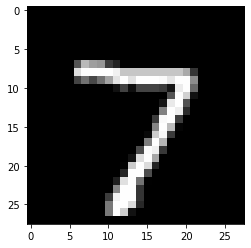

Classifier output: tensor([[ -5.8328, -11.1719,  -6.0829,  -2.3410, -17.1647, -10.6663, -25.8226,
           7.4947,  -8.8438,  -1.4734]])
Classifier prediction: 7


In [12]:
x, labels = test_iter.next()
x = x[0].unsqueeze(0)
labels = labels[0].unsqueeze(0)
imshow(x[0,0])

x = x.to(device)
labels = labels.to(device)

out = net(x).data
print('Classifier output:', out)
print('Classifier prediction:', torch.argmax(out).item())

We can also measure the classifier's accuracy on the full test dataset. This function takes in a classifier we have trained and the loader for the test set, and outputs the classifier's accuracy. The accuracy is simply
$$ \dfrac{\text{# correct}}{\text{# total}}.$$

In [13]:
def accuracy(curr_net, testloader):
    '''
    Returns the accuracy of classifier NET
    on test data from TESTLOADER.
    '''
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = curr_net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(total)
    return correct / total

In [14]:
print('Classifier accuracy on  test dataset:', accuracy(net, testloader))

10000
Classifier accuracy on  test dataset: 0.9681


## Fast Gradient Sign Method

Here, we implement the Fast Gradient Sign Method, which takes in a batch of input images, their labels, a trained classifier, and the epsilon radius within which the perturbation should lie. This function should output the input image perturbed in the direction of the sign of the gradient with respect to the classifier's loss.

(Note that the output is not guaranteed to lie in the valid range for images, since here pixel values must be in $[-1,1]$. You should use `torch.clamp` to fix the FGSM output to lie in the correct range.)

In [15]:
def FGSM(x, labels, net, eps):
    '''
    Given an input image X and its corresponding labels
    LABELS, as well as a classifier NET, returns X
    perturbed by EPS using the fast gradient sign method.
    '''
    net.zero_grad()    # Zero out any gradients from before
    x.requires_grad=True    # Keep track of gradients
    out = net(x)    # Output of classifier
    criterion = nn.CrossEntropyLoss()
    loss = criterion(out, labels)   # Classifier's loss
    loss.backward()
    grads = x.grad.data    # Gradient of loss w/r/t input
    
    # TODO: Your code here!
    return torch.clamp(x + eps * torch.sign(grads), min = -1, max = 1)

Let's see how well the classifier does when the input is adversarially perturbed using FGSM. Try this for $\varepsilon\in\{0.05, 0.1,0.2,0.3, 0.4\}$, and again remember to visualize the inputs with `imshow`.

In [22]:
epsilons = [0.05,0.1,0.2,0.3,0.4] # TODO: Try eps = 0.05, 0.1, 0.2, 0.3, 0.4

Epsilon: 0.05


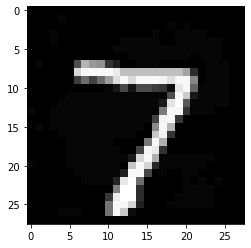

Classifier output: tensor([[ -4.5371, -10.4391,  -6.0321,  -2.4572, -15.6011,  -8.9556, -23.0967,
           5.9056,  -7.2430,  -0.8490]])
Classifier prediction: 7
Epsilon: 0.1


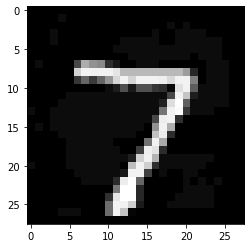

Classifier output: tensor([[ -3.2445,  -9.7079,  -5.9703,  -2.5824, -14.0059,  -7.2628, -20.3554,
           4.3316,  -5.6486,  -0.2203]])
Classifier prediction: 7
Epsilon: 0.2


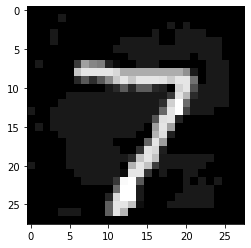

Classifier output: tensor([[ -1.7009,  -8.3720,  -5.7882,  -2.4089, -11.3181,  -4.3006, -15.5454,
           1.7447,  -3.0548,   0.3928]])
Classifier prediction: 7
Epsilon: 0.3


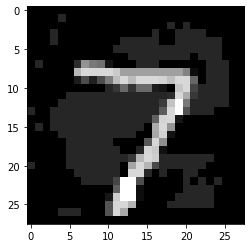

Classifier output: tensor([[ -0.6301,  -7.3552,  -5.4935,  -2.4760,  -8.7830,  -1.9136, -10.9461,
          -0.7849,  -0.6615,   0.8549]])
Classifier prediction: 9
Epsilon: 0.4


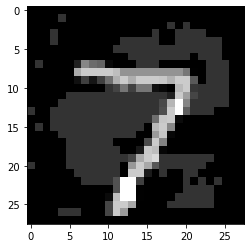

Classifier output: tensor([[-0.3191, -6.1548, -4.7887, -2.5565, -7.4729, -0.3470, -6.7920, -2.9221,
          1.3836,  0.1923]])
Classifier prediction: 8


In [23]:
for eps in epsilons:
    print(f"Epsilon: {eps}")
    x.requires_grad = True
    x_prime = FGSM(x, labels, net, eps)
    imshow(x_prime[0, 0].cpu())
    out = net(x_prime)
    print('Classifier output:', out.data)
    print('Classifier prediction:', torch.argmax(out).item())

We should evaluate the classifier's performance on FGSM-perturbed data by the same metric that we will later use in the primal adversarial problem. That is, for the classifier's output vector $\vec{\hat{z}}_3$, we want to compute
$$
\vec{c}_j^\top \vec{\hat{z}}_3
$$
where
$$\vec{c}_j={\vec{y}_{\text{true}}}-\vec{e}_{j}$$
for each $j\in[10]$.

Recall that 
$$\vec{c}_j^\top \vec{\hat{z}}_3=\vec{\hat{z}}_{3i_{\text{true}}}-\vec{\hat{z}}_{3j},$$
i.e. $\vec{c}_j^\top \vec{\hat{z}}_3$ is the difference between the classifier's confidence on the true class and the $j$th (incorrect) class. If $\vec{c}_j^\top \vec{\hat{z}}_3$ is positive for all incorrect $j$, then the classifier was not fooled by the adversarial perturbation.

In [24]:
for i in range(10):
    c = torch.zeros(10, 1).to(device)
    if i != labels:
        c[i] = -1
        c[labels] = 1
        print(i, (out @ c).item())

0 -2.603046178817749
1 3.232720375061035
2 1.8665399551391602
3 -0.3656296730041504
4 4.550755977630615
5 -2.575131893157959
6 3.869845390319824
8 -4.305716514587402
9 -3.1143994331359863


**Q: What do the $\vec{c}_j^\top \vec{\hat{z}}_3$ scores tell you about the robustness of the classifier to different values of epsilon? For a given input digit, which output categories have higher/lower scores? Why?**

A: The $\vec{c}_j^\top \vec{\hat{z}}_3$ scores represent the difference between the classifier's confidence on the true class versus the incorrect class, so a higher positive value represents a higher confidence in the true class since it wasn't fooled by the adversarial perturbation. Therefore, this means the higher the $\vec{c}_j^\top \vec{\hat{z}}_3$ value is, the more robust the classifier is. The value of $\vec{c}_j^\top \vec{\hat{z}}_3$ decreases as epsiolon increases, which indicates that robustness increases as the size of the perturbation increases. For a given input digit, the digit categories that look the most similar have lower scores since the classifier was fooled (ie for a perturbed image of a 4, the values of 9 are lower since 4 and 9 look similar). For digits that don't look similar, the output categories have a higher score (ie for a perturbed image of a 4, the values of 9 are lower since 4 and 1 do NOT look similar).

Now that FGSM is defined, we can also measure a classifier's accuracy on a dataset where each input has been adversarially perturbed. That is, for each point in the original test dataset, we first perturb it using FGSM before feeding it to the classifier.

In [25]:
def accuracy_on_FGSM(curr_net, testloader, eps):
    '''
    Returns the accuracy of classifier NET on test
    data from TESTLOADER that has been perturbed by
    EPS using FSGM.
    '''
    correct = 0
    total = 0
    for data in testloader:
        x, labels = data[0].to(device), data[1].to(device)
        x_prime = FGSM(x, labels, curr_net, eps)
        outputs = net(x_prime)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(correct / total)
    return correct / total

0.9617
0.8468
0.5469
0.2506
0.0987


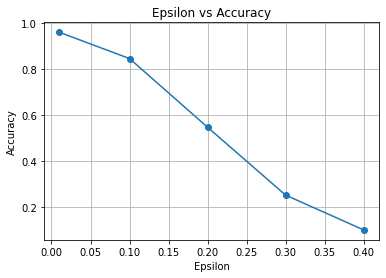

In [29]:
import matplotlib.pyplot as plt

# Define epsilon values
epsilons = [0.01, 0.1, 0.2, 0.3, 0.4]

# Initialize lists to store accuracy values
accuracies = []

# Iterate over epsilon values
for eps in epsilons:
    accuracy = accuracy_on_FGSM(net, testloader, eps)
    accuracies.append(accuracy)

# Plot epsilon vs accuracy
plt.plot(epsilons, accuracies, marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Epsilon vs Accuracy')
plt.grid(True)
plt.show()

**Q: How does the classifier accuracy on data perturbed by FGSM compare to that on the original test dataset? How does this vary with epsilon?**

A: Classifier accuracy on data perturbed by FGSM is much lower compared with the original test dataset. As epsilon increases, accuracy decreases.

## Dual Network

Here, we will implement the dual network. First, we write the function to compute upper and lower bounds for the dual network. This function should take an input image, the trained classifier, and an epsilon value, and return the tuple
$$(\vec{l},\vec{u},S,S^-,S^+)$$
where $\vec{u}$ and $\vec{l}$ are the upper and lower bounds, respectively, for the input to the ReLU layer, and $S^-,S^+,S$ are sets defined by

$$
\begin{aligned}
&S:=\{j\in [n_2]\mid l_{j}\leq 0\leq u_{j}\}\\
&S^{-}:=\{j\in [n_2]\mid l_{j}\leq u_{j}\leq 0\}\\
&S^{+}:=\{j\in [n_2]\mid 0\leq l_{j}\leq u_{j}\}.
\end{aligned}
$$

See Section 6 of the PDF for more details.

In [30]:
def dual_bounds(x, net, eps):
    '''
    Given a classifier NET, an input image X,
    and the epsilon parameter EPS, returns the lower
    and upper bounds L and U respectively, as well as
    the corresponding sets S, S_MIN, S_PLUS.
    '''
    x = x[0].reshape(-1, 1)    # Reshape input to more convenient dimensions
    W = [layer.weight for layer in net.layers]    # Array of network weights (W matrices)
    b = [layer.bias.reshape(-1, 1) for layer in net.layers]    # Array of network biases (b vectors)
    n = W[1].shape[1]    # Dimensionality of hidden layer
    W_norm_vec = torch.tensor([torch.norm(W[0], p = 1), torch.norm(W[1], p = 1)]).t()

    u = W[0] @ x + b[0] + eps*W_norm_vec[0]
    l =  W[0] @ x + b[0] - eps*W_norm_vec[0]
    
    S = [j for j in range(W[0].shape[0]) if l[j] <= 0 and 0 <= u[j]]
    S_min = [j for j in range(W[0].shape[0]) if l[j] <= u[j] and u[j] <= 0]
    S_plus = [j for j in range(W[0].shape[0]) if 0 <= l[j] and l[j] <= u[j]]
    """S = torch.nonzero((l <= 0) & (0 <= u), as_tuple=False).squeeze()
    S_min = torch.nonzero((l <= u) & (u <= 0), as_tuple=False).squeeze()
    S_plus = torch.nonzero((0 <= l) & (l <= u)).squeeze()"""
    #print(S)
    #print(l)
    #print(u)
    #print(S_min)
    #print(S_plus)
    return l, u, S, S_min, S_plus

Given the tuple $(l,u,S,S^-,S^+)$, we are ready to calculate the dual objective itself. This function should take in an input image, the classifier, a vector $c$, and the $(l,u,S,S^-,S^+)$ from the previous function in order to output 
$$
d^*(\vec{x},\vec{c})= 
-\vec{\hat{\nu}}_1^\top \vec{x}-\varepsilon\|\vec{\hat{\nu}}_1\|_1-\sum_{i=1}^{2}\vec{\nu}_{i+1}^\top \vec{b}_i+\sum_{j\in S\
}l_{j}\text{ReLU}(\nu_{2j})
$$

Where the $\vec{\nu}$ vectors are computed as
$$
\begin{aligned}
&\vec{\nu}_3=-\vec{c}\\
&\vec{\hat{\nu}}_2=W_2^\top \vec{\nu}_{3}\\
&\nu_{2j}=0 && \forall j\in S^-\\
&\nu_{2j}=\hat{\nu}_{2j} && \forall j\in S^+\\
&\nu_{2j}=\dfrac{u_{j}}{u_{j}-l_{j}}\hat{\nu}_{2j} && \forall j\in S\\
&\vec{\hat{\nu}}_1=W_1^\top \vec{\nu_{2}}
&\end{aligned}.
$$

Again, see Section 6 of the PDF for more details.

One efficient way to compute $\vec{\nu}_2$ is to rewrite it as
$$\vec{\nu}_2= D\vec{\hat{\nu}}_2,$$
where $D$ is a diagonal matrix defined  by
$$
D_{jj}=\begin{cases}
0 & j\in S^-\\
\hat{\nu}_{2j} & j\in S^+\\
\dfrac{u_{j}}{u_{j}-l_{j}}\hat{\nu}_{2j} & j\in S.
\end{cases}
$$

In [31]:
# Constructs the diagonal D matrix from the S sets, n (the dimensionality
# of the hidden layer), u, and l.
def StoD(S_min, S_plus, S, n, u, l):
    '''
    Given upper and lower bounds U and L, as well
    as the corresponding sets S_MIN, S_PLUS, and S,
    as well as the dimension of the hidden layer N,
    returns the corresponding diagonal matrix D.
    '''
    d = []
    for j in range(n):
        if j in S:
            d.append((u[j] / (u[j] - l[j])).item())
        elif j in S_plus:
            d.append(1)
        elif j in S_min:
            d.append(0)
        else:
            assert False, 'StoD error.'
    return torch.diag(torch.Tensor(d)).to(device)

def dual_forward(x, net, c, eps, l, u, S, S_min, S_plus):
    '''
    Calculates the dual objective for classifier NET with input X
    and dual input C and epsilon parameter S. Depends on lower
    and upper bounds L and U, as well as the corresponding sets
    S, S_MIN, S_PLUS.
    '''
    x = x[0].reshape(-1, 1)    # Reshape input to more convenient dimensions
    W = [layer.weight for layer in net.layers]    # Array of network weights (W matrices)
    b = [layer.bias.reshape(-1, 1) for layer in net.layers]    # Array of network biases (b vectors)
    n = W[1].shape[1]    # Dimensionality of hidden layer
    D = StoD(S_min, S_plus, S, n, u, l)
    # TODO: Your code here!
    v_3 = -c
    v_hat_2 = W[1].T @ v_3
    v_2 = D @ v_hat_2
    v_hat_1 = (W[0].T @ v_2)
    
    sum_l_S = 0
    
    return ((-v_hat_1.T @ x) - eps*torch.norm(v_hat_1, p = 1) - (v_2.T @ b[0]) - (v_3.T @ b[1]) + torch.sum(l[S] * torch.relu(v_2[list(S)])))

Now, we can use the dual network to check the robustness of the network we just trained on sample input images. We can do this for 
$$\vec{c}_j={\vec{y}_{\text{true}}}-\vec{e}_{j}$$
for each $j\in[10]$.

The output is a vector where the $j$th element is the difference between the model's confidence in the true class and the $j$th class; if $d^*(\vec{x},\vec{c}_j)$ is nonnegative for every $j\in[10]$, then we know the model is robust to perturbations of size $\varepsilon$. See Section 8 of the PDF for more details.

Try running the following block of code for different values of $\varepsilon\in\{0.05, 0.1, 0.2, 0.3, 0.4\}$, and compare the robustness guarantees here with the classifier's performance on the FGSM data from before.

In [32]:
eps = 0.2 # TODO: Try eps = 0.05, 0.1, 0.2, 0.3, 0.4

In [33]:
# We are still using the same sample input x as before.
l, u, S, S_min, S_plus = dual_bounds(x, net, eps)

# Here, we loop through each column c_j defined above, and output the 
# objective value for the dual function with input c.
for i in range(10):
    c = torch.zeros(10, 1).to(device)
    if i != labels:
        c[i] = -1
        c[labels] = 1
        print(i, dual_forward(x, net, c, eps, l, u, S, S_min, S_plus).item())

0 -7925.1806640625
1 -7479.29833984375
2 -7709.80419921875
3 -7984.5947265625
4 -7361.39794921875
5 -9097.4794921875
6 -8703.580078125
8 -7412.47216796875
9 -7900.9951171875


In [36]:
# We are still using the same sample input x as before.
l, u, S, S_min, S_plus = dual_bounds(x, net, eps)

# Here, we loop through each column c_j defined above, and output the 
# objective value for the dual function with input c.
for i in range(10):
    c = torch.zeros(10, 1).to(device)
    if i != labels:
        c[i] = -1
        c[labels] = 1
        print(i, dual_forward(x, net, c, eps, l, u, S, S_min, S_plus).item())

0 -7925.1806640625
1 -7479.29833984375
2 -7709.80419921875
3 -7984.5947265625
4 -7361.39794921875
5 -9097.4794921875
6 -8703.580078125
8 -7412.47216796875
9 -7900.9951171875


**Q: What do the dual network outputs tell you about the robustness of the classifier? How does this compare to the classifier's performance (in particular, the $\vec{c}_j^\top \vec{\hat{z}}_3$ scores) on FGSM outputs? How does your answer change with epsilon?**

A: The dual network outputs correspond with the robustness of the classifier, so when the dual network returns nonnegative values, we have a "certificate of robustness" that indicates our classifier is robust against the adversarial perturbation. Our outputs are all negative, indicating that our network is not robust, which is the opposite conclusion from the $\vec{c}_j^\top \vec{\hat{z}}_3$ scores on FGSM outputs. Our answer gets more and more negative as epsilon increases since robustness decreases with larger perturbations

**Q: Suppose you have a deep neural classifier that you want to defend against adversarial attacks. That is, you want to detect and discard any input images that were possibly adversarially perturbed. How might you do this with the robustness certificate you have implemented?**

A: I would pass through the input image through the dual bounds and check the robustness certificate. If most values were nonnegative, then that means the classifier is robust and we should keep those images. If all values were extremely negative, as seen with the images perturbed by FGSM, we would discard those images. 

## Robust training

The following function should implement the robust loss from the PDF. This loss is an upper bound on the worst-case loss within an $\epsilon$ ball of the original training input. Thus, training using this new loss should result in a classifier that is more robust than one trained on the original cross-entropy loss.

There are no mandatory questions here, but feel free to experiment with this robust training, and compare the performance here (measured by the dual objective certificate, as well as original/FGSM accuracy) to that of the original. You can also try training a model using the original loss first, then fine-tuning with the robust loss.

In [37]:
def robust_loss(x, label, net, eps, criterion):
    '''
    Given a batch of input images X, its corresponding lables LABEL,
    the classifier NET, epsilon value EPS, and original loss
    function CRITERION, returns the robust loss of NET w/r/t
    the original loss function, on the input image.
    '''
    label = label.long()
    l, u, S, S_min, S_plus = dual_bounds(x, net, eps)
    # We assume there are 10 classes.
    e_y = torch.zeros(10, 1)
    e_y[label] = 1
    c = e_y @ torch.ones(1, 10) - torch.eye(10)
    J = dual_forward(x, net, c, eps, l, u, S, S_min, S_plus).unsqueeze(0)
    return criterion(-J, label.unsqueeze(0))

In [38]:
from tqdm import tqdm

def robust_train(net, criterion, trainloader, eps, lr=0.001):
    '''
    Trains the classifier NET using the robust version
    of the original loss function CRITERION with paramater EPS,
    using training data from TRAINLOADER and with learning rate LR.
    
    Note that we half the learning rate each epoch.
    '''
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    for epoch in range(3):
        # Initialize tqdm progress bar for the epoch
        pbar_epoch = tqdm(enumerate(trainloader), total=len(trainloader), desc=f'Epoch {epoch}')

        for i, data in pbar_epoch:
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * 0.5 ** epoch

            inputs, labels = data
            optimizer.zero_grad()
            loss = 0

            for i in range(inputs.shape[0]):
                x = inputs[i].unsqueeze(0)
                label = labels[i].unsqueeze(0)
                loss += robust_loss(x, label, net, eps, criterion)

            loss.backward()
            optimizer.step()

            # Update tqdm progress bar description with current loss
            pbar_epoch.set_postfix({'Loss': loss.item()})

    print("Training complete.")

In [126]:
net_robust = Net()
net_robust.to(device)

criterion = nn.CrossEntropyLoss()

robust_train(net_robust, criterion, trainloader, 0.01)

Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [06:27<00:00, 12.91it/s, Loss=0.925]

Training complete.


In [127]:
# Define the file path where you want to save the weights
weights_path = 'robust_net_weights.pth'

# Save the state_dict of the network
torch.save(net_robust.state_dict(), weights_path)

In [154]:
net_robust_60k = Net()
net_robust_60k.to(device)

criterion = nn.CrossEntropyLoss()

robust_train(net_robust_sparse, criterion, full_trainloader, 0.001)

# Define the file path where you want to save the weights
weights_path = 'robust_net_60k_weights.pth'

# Save the state_dict of the network
torch.save(net_robust_60k.state_dict(), weights_path)

Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [17:54<00:00, 13.95it/s, Loss=0]

Training complete.


0.9683
0.9684
0.9674
0.9662
0.9641


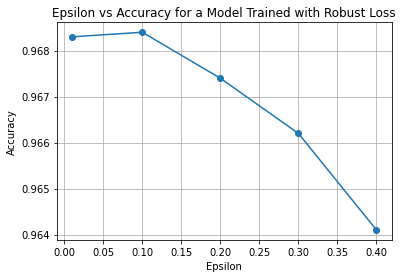

In [40]:
# Define epsilon values
epsilons = [0.01, 0.1, 0.2, 0.3, 0.4]

# Initialize lists to store accuracy values
accuracies = []

# Iterate over epsilon values
for eps in epsilons:
    accuracy = accuracy_on_FGSM(net_robust_60k, testloader, eps)
    accuracies.append(accuracy)

# Plot epsilon vs accuracy
plt.plot(epsilons, accuracies, marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Epsilon vs Accuracy for a Model Trained with Robust Loss')
plt.grid(True)
plt.show()

In [41]:
# We are still using the same sample input x as before.

eps = 0.01
l, u, S, S_min, S_plus = dual_bounds(x, net_robust_60k, eps)

# Here, we loop through each column c_j defined above, and output the 
# objective value for the dual function with input c.
for i in range(10):
    c = torch.zeros(10, 1).to(device)
    if i != labels:
        c[i] = -1
        c[labels] = 1
        print(i, dual_forward(x, net_robust_60k, c, eps, l, u, S, S_min, S_plus).item())

0 -92.96980285644531
1 -95.76985931396484
2 -94.37602996826172
3 -103.28253936767578
4 -104.45116424560547
5 -101.85345458984375
6 -105.2235107421875
8 -106.81745147705078
9 -101.82561492919922
